In [41]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# technical analysis
import ta

# Pyfolio
import pyfolio as pf

## data: 5 minutes data

In [42]:
df_ = pd.read_csv('C:ethusd5min.csv')
df = df_.set_index('timestamp')
df.index = pd.to_datetime(df.index)
df

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2020-04-10 00:00:00,169.56,169.72,169.41,169.43,2906.41820,1586477099999,4.930542e+05,707,2260.79119,3.835677e+05,0
2020-04-10 00:05:00,169.44,169.59,168.92,169.22,3376.45186,1586477399999,5.711061e+05,1004,1951.63764,3.301054e+05,0
2020-04-10 00:10:00,169.23,169.42,168.70,168.78,3007.20677,1586477699999,5.081008e+05,752,929.71120,1.571687e+05,0
2020-04-10 00:15:00,168.84,169.12,168.80,169.00,1465.81110,1586477999999,2.476386e+05,472,637.17163,1.076405e+05,0
2020-04-10 00:20:00,168.99,169.40,168.96,169.36,1067.16710,1586478299999,1.806507e+05,418,343.42918,5.811992e+04,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-04-09 23:40:00,2066.80,2069.36,2065.89,2067.74,696.35201,1618011899999,1.439804e+06,1078,350.52749,7.246912e+05,0
2021-04-09 23:45:00,2067.75,2070.85,2067.62,2070.42,1039.88778,1618012199999,2.152313e+06,1344,554.96546,1.148618e+06,0
2021-04-09 23:50:00,2070.42,2070.95,2069.05,2069.52,773.88383,1618012499999,1.601904e+06,1142,428.07969,8.860856e+05,0


In [43]:
close = pd.to_numeric(df.close)

## Envelope Strategy

- SMA 10 periods
- up and down 1%

In [44]:
window = 20

sma = ta.trend.sma_indicator(close,window)
smaup = sma*1.01
smadown = sma*0.99

In [45]:
longs = pd.Series(1, smadown.loc[np.sign(close-smadown).diff() == 2].index)
shorts = pd.Series(-1, smaup.loc[np.sign(smaup-close).diff() == -2].index)

In [46]:
signals = pd.concat([longs,shorts]).sort_index()

In [47]:
signals = signals.diff().dropna()*.5 # drop when same signal follows
signals = signals.loc[signals!=0]

In [48]:
signals

timestamp
2020-04-10 16:55:00   -1.0
2020-04-10 22:50:00    1.0
2020-04-11 21:50:00   -1.0
2020-04-12 22:30:00    1.0
2020-04-13 11:35:00   -1.0
                      ... 
2021-04-07 13:10:00   -1.0
2021-04-07 15:40:00    1.0
2021-04-07 20:00:00   -1.0
2021-04-08 00:10:00    1.0
2021-04-08 04:35:00   -1.0
Length: 873, dtype: float64

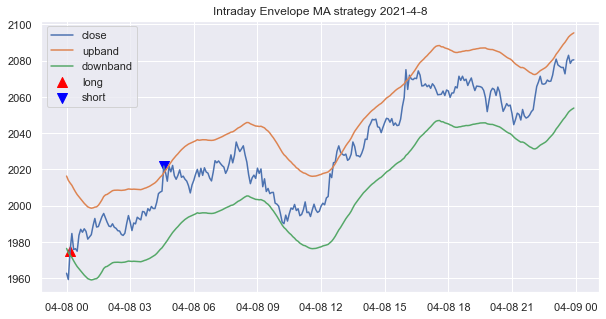

In [49]:
# Intraday
#sc = signals
title =  'Intraday Envelope MA strategy'
long = close.loc[signals.loc[signals==1].index]
short = close.loc[signals.loc[signals==-1].index]


day = ' 2021-4-8'
s = 100

plt.figure(figsize=(10,5))
plt.plot(close.loc[day])
plt.plot(smaup.loc[day])
plt.plot(smadown.loc[day])
plt.scatter(long.loc[day].index, long.loc[day],s=s, c='red',marker='^', alpha=1)
plt.scatter(short.loc[day].index, short.loc[day],s=s, c='blue',marker='v', alpha=1)
plt.legend(['close','upband','downband','long','short'])
plt.title(title + day)
plt.show()

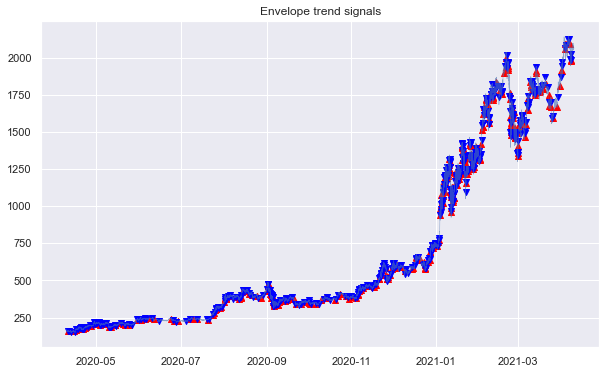

In [50]:
sc = signals
title =  'Envelope trend signals'

plt.figure(figsize=(10,6))
plt.plot(close, linewidth=0.5,alpha=0.6)
plt.scatter(long.index, long, c='red',marker='^', alpha=1)
plt.scatter(short.index, short, c='blue',marker='v', alpha=1)

plt.title(title)
plt.show()

In [51]:
mult = (signals+1)/2
rets = (close.loc[signals.index].pct_change().shift(-1))*mult
rets = rets.loc[rets!=0].dropna()

In [52]:
rets

timestamp
2020-04-10 22:50:00   -0.004316
2020-04-12 22:30:00   -0.035223
2020-04-15 00:30:00   -0.025337
2020-04-16 10:40:00    0.023770
2020-04-17 00:25:00    0.008749
                         ...   
2021-04-05 23:15:00    0.014904
2021-04-06 02:05:00    0.004599
2021-04-07 01:05:00   -0.046236
2021-04-07 15:40:00    0.002659
2021-04-08 00:10:00    0.023680
Length: 435, dtype: float64

In [53]:
rets.describe()

count    435.000000
mean       0.000929
std        0.025818
min       -0.105523
25%       -0.011037
50%        0.008964
75%        0.017265
max        0.049836
dtype: float64

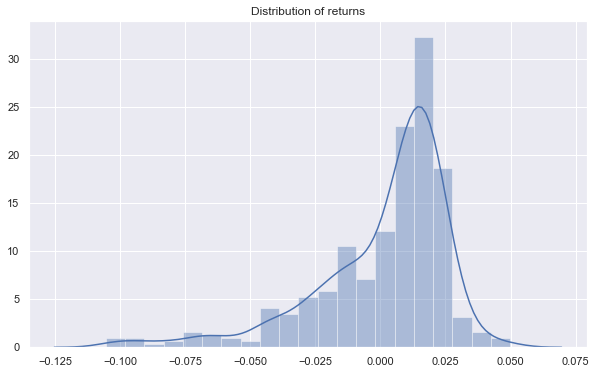

In [54]:
plt.figure(figsize=(10,6))
sns.distplot(rets)
plt.title('Distribution of returns')
plt.show()

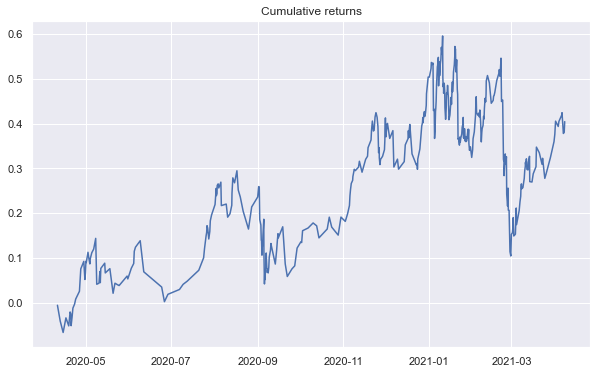

In [55]:
plt.figure(figsize=(10,6))
plt.plot(rets.cumsum())
plt.title('Cumulative returns')
plt.show()

In [56]:
SR = rets.mean()/rets.std()
print('Total Sharpe Ratio: ',SR)

Total Sharpe Ratio:  0.03599278961631045
